# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [132]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

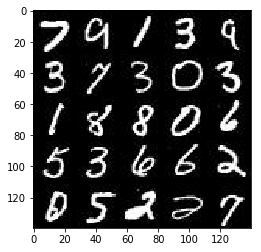

In [133]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

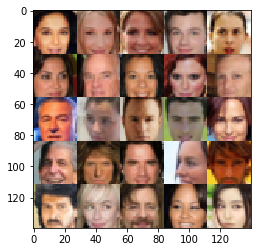

In [134]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [135]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [136]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_image')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return inputs_image, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [155]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    leaky_alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse) as discriminator_scope:
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(leaky_alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(leaky_alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(leaky_alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [156]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    leaky_alpha = 0.2
    with tf.variable_scope('generator', reuse=not(is_train)) as generator_scope:
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(leaky_alpha * x1, x1)
        #4x4x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(leaky_alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(leaky_alpha * x3, x3)
        #14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        #28x28xout
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [157]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [158]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [159]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [160]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_image, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_image, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_opt, {input_image: batch_images, input_z: batch_z})
                sess.run(g_opt, {input_z: batch_z})
                
                # At the end of each epoch, get the losses and print them out
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_image: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0469... Generator Loss: 0.1971
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 0.2169... Generator Loss: 1.7912
Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 2.6018
Epoch 1/2... Discriminator Loss: 0.1888... Generator Loss: 1.9679
Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 2.1777
Epoch 1/2... Discriminator Loss: 0.1059... Generator Loss: 2.5504
Epoch 1/2... Discriminator Loss: 0.0546... Generator Loss: 3.3250
Epoch 1/2... Discriminator Loss: 0.0554... Generator Loss: 3.3064


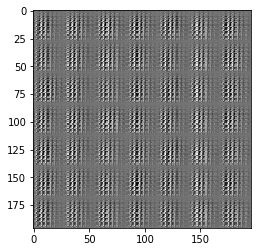

Epoch 1/2... Discriminator Loss: 0.0488... Generator Loss: 3.3072
Epoch 1/2... Discriminator Loss: 0.0708... Generator Loss: 3.0096
Epoch 1/2... Discriminator Loss: 0.0840... Generator Loss: 2.8481
Epoch 1/2... Discriminator Loss: 0.1592... Generator Loss: 2.7485
Epoch 1/2... Discriminator Loss: 0.0667... Generator Loss: 3.3920
Epoch 1/2... Discriminator Loss: 0.1266... Generator Loss: 2.7190
Epoch 1/2... Discriminator Loss: 0.1377... Generator Loss: 3.1383
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 4.8444
Epoch 1/2... Discriminator Loss: 0.2588... Generator Loss: 2.6000
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.2754


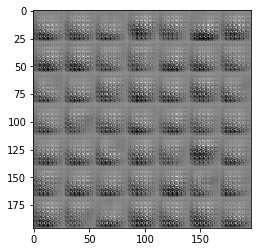

Epoch 1/2... Discriminator Loss: 0.3515... Generator Loss: 2.2452
Epoch 1/2... Discriminator Loss: 0.1746... Generator Loss: 3.4376
Epoch 1/2... Discriminator Loss: 0.2175... Generator Loss: 2.2831
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.3984
Epoch 1/2... Discriminator Loss: 0.2103... Generator Loss: 2.5227
Epoch 1/2... Discriminator Loss: 0.1233... Generator Loss: 3.3592
Epoch 1/2... Discriminator Loss: 0.2586... Generator Loss: 2.3105
Epoch 1/2... Discriminator Loss: 0.2064... Generator Loss: 2.4357
Epoch 1/2... Discriminator Loss: 0.0841... Generator Loss: 3.3767
Epoch 1/2... Discriminator Loss: 0.1453... Generator Loss: 2.8838


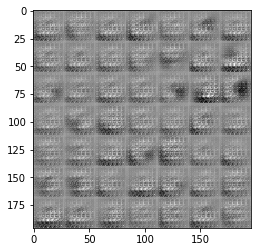

Epoch 1/2... Discriminator Loss: 0.3184... Generator Loss: 4.2172
Epoch 1/2... Discriminator Loss: 0.1074... Generator Loss: 3.3843
Epoch 1/2... Discriminator Loss: 0.0785... Generator Loss: 3.4506
Epoch 1/2... Discriminator Loss: 0.0963... Generator Loss: 3.8559
Epoch 1/2... Discriminator Loss: 0.0829... Generator Loss: 3.2470
Epoch 1/2... Discriminator Loss: 0.1137... Generator Loss: 3.4666
Epoch 1/2... Discriminator Loss: 0.0835... Generator Loss: 3.2619
Epoch 1/2... Discriminator Loss: 0.0589... Generator Loss: 3.6681
Epoch 1/2... Discriminator Loss: 0.1702... Generator Loss: 4.0751
Epoch 1/2... Discriminator Loss: 0.1336... Generator Loss: 2.7005


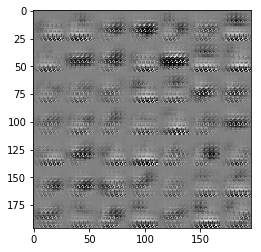

Epoch 1/2... Discriminator Loss: 0.1251... Generator Loss: 2.9006
Epoch 1/2... Discriminator Loss: 0.0710... Generator Loss: 3.6762
Epoch 1/2... Discriminator Loss: 0.0923... Generator Loss: 3.2719
Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 2.9886
Epoch 1/2... Discriminator Loss: 0.0891... Generator Loss: 3.3318
Epoch 1/2... Discriminator Loss: 0.1531... Generator Loss: 2.9514
Epoch 2/2... Discriminator Loss: 0.3549... Generator Loss: 4.5923
Epoch 2/2... Discriminator Loss: 4.1516... Generator Loss: 11.7011
Epoch 2/2... Discriminator Loss: 0.4153... Generator Loss: 1.4416
Epoch 2/2... Discriminator Loss: 0.1996... Generator Loss: 2.4992


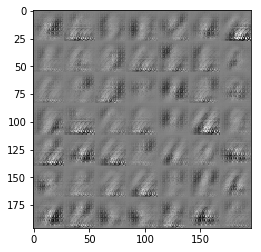

Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 0.3104... Generator Loss: 2.5334
Epoch 2/2... Discriminator Loss: 0.4847... Generator Loss: 1.9223
Epoch 2/2... Discriminator Loss: 0.4433... Generator Loss: 2.7439
Epoch 2/2... Discriminator Loss: 0.4355... Generator Loss: 2.7177
Epoch 2/2... Discriminator Loss: 0.6834... Generator Loss: 2.2313
Epoch 2/2... Discriminator Loss: 0.4871... Generator Loss: 1.9067
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 0.9088


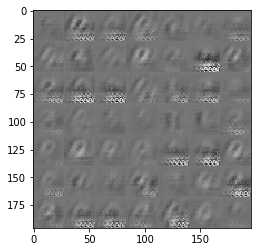

Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 1.5945
Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 2.3889
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.4463
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 2.6673
Epoch 2/2... Discriminator Loss: 0.7453... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.3952
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.7338
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 0.9701


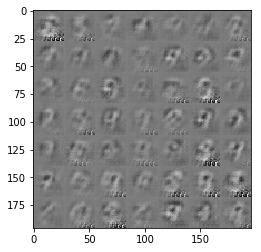

Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 0.6228... Generator Loss: 1.4928
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 1.6615
Epoch 2/2... Discriminator Loss: 0.6897... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.6285... Generator Loss: 1.8318
Epoch 2/2... Discriminator Loss: 0.7214... Generator Loss: 1.4011
Epoch 2/2... Discriminator Loss: 0.7450... Generator Loss: 1.7383
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.8547
Epoch 2/2... Discriminator Loss: 1.4572... Generator Loss: 0.3650


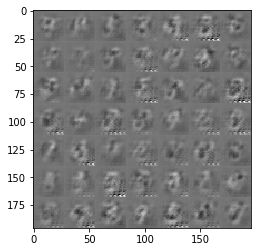

Epoch 2/2... Discriminator Loss: 0.9069... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 2.0521
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.3744
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.3947
Epoch 2/2... Discriminator Loss: 0.6813... Generator Loss: 1.5645
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 1.6549


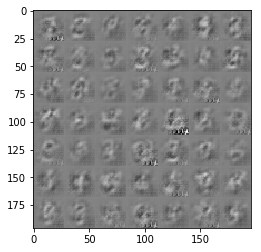

Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.1315
Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 0.7979


In [161]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.3446... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.0494
Epoch 1/1... Discriminator Loss: 0.1448... Generator Loss: 2.3161
Epoch 1/1... Discriminator Loss: 0.1175... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 0.1359... Generator Loss: 2.5643
Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 2.2525
Epoch 1/1... Discriminator Loss: 0.1213... Generator Loss: 2.6363


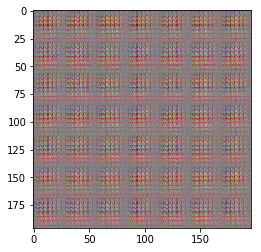

Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 3.2590
Epoch 1/1... Discriminator Loss: 0.1002... Generator Loss: 2.9271
Epoch 1/1... Discriminator Loss: 0.1723... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 2.8269
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 2.9900
Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.1426... Generator Loss: 2.5245
Epoch 1/1... Discriminator Loss: 0.1011... Generator Loss: 3.1720
Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 2.9731
Epoch 1/1... Discriminator Loss: 0.0892... Generator Loss: 3.4609


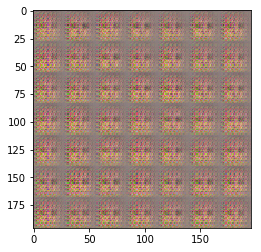

Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 3.2082
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.7872
Epoch 1/1... Discriminator Loss: 0.0921... Generator Loss: 3.1978
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 3.3871
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.2514
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 3.1983
Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 3.6184
Epoch 1/1... Discriminator Loss: 0.0461... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 3.6754
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 3.6133


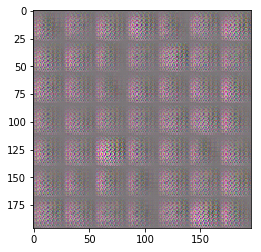

Epoch 1/1... Discriminator Loss: 0.0595... Generator Loss: 3.3482
Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 3.7760
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 3.7924
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 3.8574
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 3.5935
Epoch 1/1... Discriminator Loss: 0.0408... Generator Loss: 3.6185
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 3.6535
Epoch 1/1... Discriminator Loss: 0.0947... Generator Loss: 3.1008
Epoch 1/1... Discriminator Loss: 0.0570... Generator Loss: 3.8998


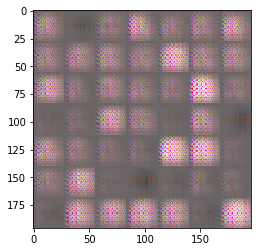

Epoch 1/1... Discriminator Loss: 0.0741... Generator Loss: 3.5284
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.4809
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 3.5043
Epoch 1/1... Discriminator Loss: 0.0997... Generator Loss: 4.0059
Epoch 1/1... Discriminator Loss: 0.1073... Generator Loss: 3.2301
Epoch 1/1... Discriminator Loss: 0.3976... Generator Loss: 3.9909
Epoch 1/1... Discriminator Loss: 0.1892... Generator Loss: 3.1446
Epoch 1/1... Discriminator Loss: 0.1182... Generator Loss: 2.7170
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 1.8592


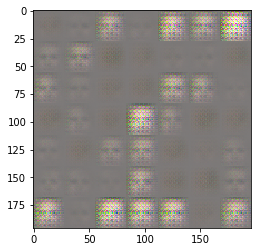

Epoch 1/1... Discriminator Loss: 0.2048... Generator Loss: 2.7918
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 0.0785... Generator Loss: 3.8550
Epoch 1/1... Discriminator Loss: 0.1490... Generator Loss: 3.3979
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 3.4434
Epoch 1/1... Discriminator Loss: 0.1545... Generator Loss: 3.6918
Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 3.4880
Epoch 1/1... Discriminator Loss: 0.1094... Generator Loss: 4.1729
Epoch 1/1... Discriminator Loss: 0.1185... Generator Loss: 5.2678
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 3.2858


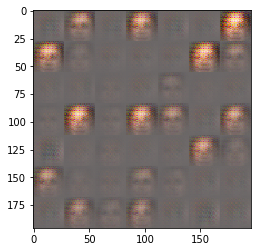

Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 3.3759
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 3.2557
Epoch 1/1... Discriminator Loss: 0.2524... Generator Loss: 2.2501
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 3.5795
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 3.3673
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.3741
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.9725
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 2.7809


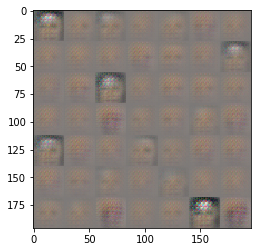

Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 6.2826
Epoch 1/1... Discriminator Loss: 0.1467... Generator Loss: 4.1476
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 2.9693
Epoch 1/1... Discriminator Loss: 0.2573... Generator Loss: 2.2971
Epoch 1/1... Discriminator Loss: 0.2520... Generator Loss: 2.2478
Epoch 1/1... Discriminator Loss: 0.1864... Generator Loss: 4.8740
Epoch 1/1... Discriminator Loss: 0.2436... Generator Loss: 2.4488
Epoch 1/1... Discriminator Loss: 0.5135... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 3.2846
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 3.4415


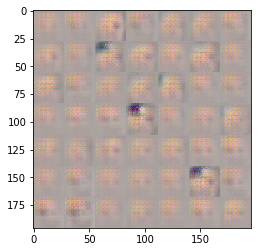

Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 0.2014... Generator Loss: 5.4421
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 1.7854
Epoch 1/1... Discriminator Loss: 0.2438... Generator Loss: 2.3840
Epoch 1/1... Discriminator Loss: 0.2075... Generator Loss: 2.5183
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 1.3799
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 5.0498
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 5.4344
Epoch 1/1... Discriminator Loss: 0.1798... Generator Loss: 2.6494
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 3.3195


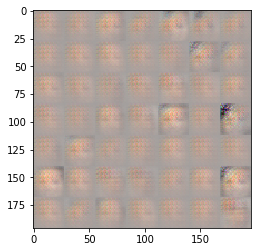

Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 6.8843
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 3.0408
Epoch 1/1... Discriminator Loss: 0.1420... Generator Loss: 3.2823
Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 1.7453
Epoch 1/1... Discriminator Loss: 0.1961... Generator Loss: 5.4378
Epoch 1/1... Discriminator Loss: 0.2437... Generator Loss: 2.8695
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 3.4139
Epoch 1/1... Discriminator Loss: 0.2527... Generator Loss: 3.1135
Epoch 1/1... Discriminator Loss: 0.2598... Generator Loss: 3.1545
Epoch 1/1... Discriminator Loss: 0.1046... Generator Loss: 4.1993


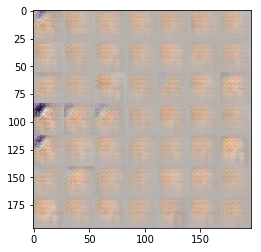

Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.2963
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 3.3682
Epoch 1/1... Discriminator Loss: 0.3774... Generator Loss: 1.7327
Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 1.6942
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 2.6827
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 2.0929
Epoch 1/1... Discriminator Loss: 0.0426... Generator Loss: 6.8713
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 1.2790


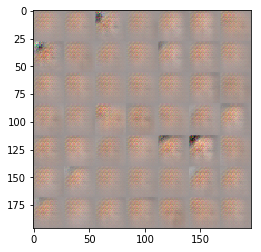

Epoch 1/1... Discriminator Loss: 0.0811... Generator Loss: 5.0538
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 7.4864
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 4.2513
Epoch 1/1... Discriminator Loss: 0.3169... Generator Loss: 5.1064
Epoch 1/1... Discriminator Loss: 0.2451... Generator Loss: 3.1794
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 4.6516
Epoch 1/1... Discriminator Loss: 0.2012... Generator Loss: 2.9409
Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 1.4124
Epoch 1/1... Discriminator Loss: 0.1685... Generator Loss: 4.0023


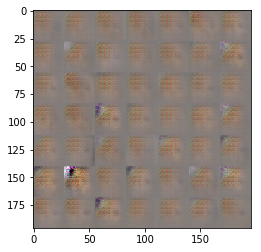

Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 5.2614
Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 5.0736
Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 3.1957
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 5.9050
Epoch 1/1... Discriminator Loss: 0.1124... Generator Loss: 3.2673
Epoch 1/1... Discriminator Loss: 0.2390... Generator Loss: 3.9405
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 5.9111
Epoch 1/1... Discriminator Loss: 0.3078... Generator Loss: 2.9450
Epoch 1/1... Discriminator Loss: 0.1432... Generator Loss: 4.0533
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 9.4758


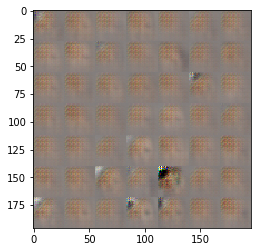

Epoch 1/1... Discriminator Loss: 0.1561... Generator Loss: 3.3128
Epoch 1/1... Discriminator Loss: 0.0914... Generator Loss: 11.4085
Epoch 1/1... Discriminator Loss: 0.1716... Generator Loss: 2.9368
Epoch 1/1... Discriminator Loss: 0.0889... Generator Loss: 9.0530
Epoch 1/1... Discriminator Loss: 0.1281... Generator Loss: 4.8308
Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 3.1199
Epoch 1/1... Discriminator Loss: 0.1154... Generator Loss: 5.2095
Epoch 1/1... Discriminator Loss: 0.2237... Generator Loss: 5.5479
Epoch 1/1... Discriminator Loss: 0.2664... Generator Loss: 2.5404
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 0.9690


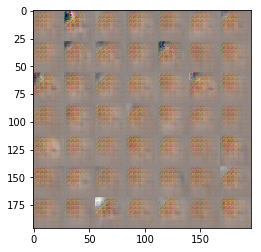

Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 5.3068
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 3.6288
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 5.8109
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 5.8109
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 7.9471
Epoch 1/1... Discriminator Loss: 0.1396... Generator Loss: 3.5896
Epoch 1/1... Discriminator Loss: 0.1129... Generator Loss: 4.3691
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 3.9356
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 1.6414


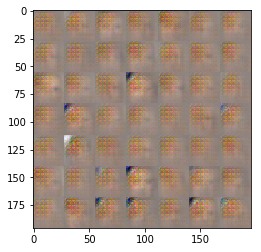

Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.2371... Generator Loss: 7.8009
Epoch 1/1... Discriminator Loss: 0.1449... Generator Loss: 3.8650
Epoch 1/1... Discriminator Loss: 0.2563... Generator Loss: 13.7219
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 2.5353
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 5.7544
Epoch 1/1... Discriminator Loss: 0.2277... Generator Loss: 2.2676
Epoch 1/1... Discriminator Loss: 0.1920... Generator Loss: 2.9227


In [162]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.